<a href="https://colab.research.google.com/github/lewinantao/Face_mask_detection/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the required Packages


In [ ]:
!pip install xmltodict --upgrade  # this will install xmltodict library

# importing other libraries
import cv2
import os
import random
import xmltodict

from PIL import Image
import PIL  

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import lxml.etree

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D

from keras.layers import LeakyReLU

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import EfficientNetB1, VGG19, ResNet50V2, InceptionV3, MobileNet, DenseNet201


from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns


# Link : https://www.kaggle.com/ashishks777/face-mask-detection-dei

## Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = '/content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset'
image_dir = os.path.join(base_dir, 'images/')
annot_dir = os.path.join(base_dir,'annotations/')

In [ ]:
print('Image Path      :',image_dir)
print('Annotation Path :',annot_dir)

Image Path      : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/images/
Annotation Path : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/annotations/


In [ ]:
train_dir = os.path.join(base_dir, 'train_images/')
test_dir = os.path.join(base_dir,'test_images/')

In [ ]:
print('Train Folder  :',train_dir)
print('Test Folder   :',test_dir)

Train Folder  : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/train_images/
Test Folder   : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/test_images/


In [ ]:
data_aug_dir_incorrectmask = os.path.join(base_dir,'dataaugmented_incorrectmask/')
data_aug_dir_withoutmask = os.path.join(base_dir,'dataaugmented_withoutmask/')

In [ ]:
print('Data Augmented Incorrect Mask Folder  :',data_aug_dir_incorrectmask)
print('Data Augmented Without Mask Folder    :',data_aug_dir_withoutmask)

Data Augmented Incorrect Mask Folder  : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/dataaugmented_incorrectmask/
Data Augmented Without Mask Folder    : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/dataaugmented_withoutmask/


In [ ]:
modelpath = os.path.join(base_dir,'saved_models/')
print('Saved Models Folder   :',modelpath)

Saved Models Folder   : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/saved_models/


In [ ]:
savedimages = os.path.join(base_dir,'saved_images/')
print('Saved Images/Plots Folder   :',savedimages)

Saved Images/Plots Folder   : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/saved_images/


## Exploratory Data Analysis

Let us see what data our dataset has





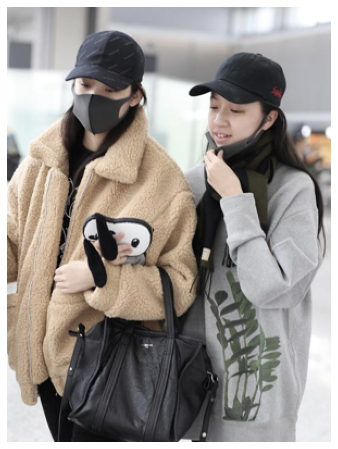

True

In [ ]:
#reading an sample image from the dataset 
img = cv2.imread(os.path.join(image_dir,'maksssksksss459.png'))
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)   #converting it from RGB to BGR

plt.figure(figsize=(8,8))                       # specifying the size of image to be printed
plt.imshow(out_img)                             # printing the image
plt.axis('off')                           
plt.show()

os.chdir(savedimages)
cv2.imwrite('sample_image.jpg', img)             #  saving the image

In [ ]:
#printing the annotations file of the above image
# tree = lxml.etree.parse("/content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/annotations/maksssksksss244.xml")
tree = lxml.etree.parse(os.path.join(annot_dir,'maksssksksss459.xml'))

pretty = lxml.etree.tostring(tree, encoding="unicode", pretty_print=True)
print(pretty)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss459.png</filename>
    <size>
        <width>298</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>60</xmin>
            <ymin>67</ymin>
            <xmax>115</xmax>
            <ymax>117</ymax>
        </bndbox>
    </object>
    <object>
        <name>mask_weared_incorrect</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>77</ymin>
            <xmax>239</xmax>
            <ymax>134</ymax>
        </bndbox>
    </object>
</annotation>



Label : with_mask
Label : mask_weared_incorrect


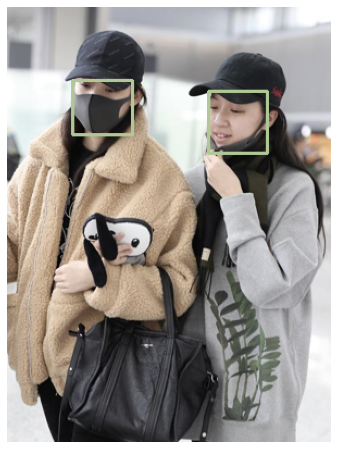

In [ ]:
# this function helps to extract the coordinates of the rectangles that bound the faces in these images
labels=[]
def face_extraction(directory_load_image,directory_load_notation):
   #opening the annotations file in readable format so that useful data can be extracted from it
        with open(os.path.join(directory_load_notation,"maksssksksss459.xml" ), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]
            file="maksssksksss459.xml"


            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        
                        cv2.rectangle(out_img,(xmin,ymin),(xmax,ymax),(175,200,150),2)#printing a rectangle around the face
                        labels.append(object_["name"])
        #printing the  new image
        
        plt.figure(figsize=(8,8))
        plt.imshow(out_img)   
        plt.axis('off')
        return labels
# executing the function  
labels=face_extraction(image_dir,annot_dir)

for labels in labels:
    print('Label :',labels)

In [ ]:
def face_extraction(directory_load_image,directory_load_notation):
    labels = []
     
    for file in os.listdir(directory_load_notation):
        with open(os.path.join(directory_load_notation, file), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]


            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        
                        labels.append(object_["name"])
                            
            else:
                #same thing on images with one face in them
                object_ = object_list
                xmin = int(object_["bndbox"]["xmin"])
                xmax = int(object_["bndbox"]["xmax"])
                ymin = int(object_["bndbox"]["ymin"])
                ymax = int(object_["bndbox"]["ymax"])

                labels.append(object_["name"])
               
                
    labels = np.asarray(labels)
    
    return labels
labels=face_extraction(image_dir,annot_dir)
print(labels.shape)
print(collections.Counter(labels))


(4072,)
Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


In [ ]:
# Converting to dataframe
dictionary = dict(collections.Counter(labels))
df = pd.DataFrame(dictionary.items(), columns=['Labels',	'Record Count'])

In [ ]:
df.head()

,Labels,Record Count
0,with_mask,3232
1,without_mask,717
2,mask_weared_incorrect,123


In [ ]:
df['Record Count'].sum()

4072

In [ ]:
# Summary of all the numeric columns of the dataset
df.describe()

,Record Count
count,3.000000
mean,1357.333333
std,1650.451554
min,123.000000
25%,420.000000
50%,717.000000
75%,1974.500000
max,3232.000000


In [ ]:
np.round(df['Record Count'].sum(),2).mean()

4072.0

======================== Data Summary ========================
- Total Images: 853
--------------------------------------------------------------
- Total Annoted Faces: 4072
- Total Faces with Masks: 3232/79.0%
- Total Faces without Masks: 717/18.0%
- Total Faces with Improper Masks: 123/3.0%
--------------------------------------------------------------
- Average Face Count Per Image: 4.8
- Median Face Count Per Image: 2.0
- Median Face Count with mask Per Image: 2.0
- Median Face Count without/improper mask Per Image: 0.0


In [ ]:
print("======================== Data Summary ========================")
print("Total Images: 853")
print('--------------------------------------------------------------')
print(f"Total Annoted Faces: {df['Record Count'].sum()}")
print('--------------------------------------------------------------')
print(f"Total Faces with Masks: {np.round(df['Record Count'].values[0])}")
print(f"Total Faces with Masks(Percentage-wise): {np.round(df['Record Count'].values[0]/df['Record Count'].sum()*100,2)}%")
print('--------------------------------------------------------------')
print(f"Total Faces without Masks: {np.round(df['Record Count'].values[1])}")
print(f"Total Faces without Masks(Percentage-wise): {np.round(df['Record Count'].values[1]/df['Record Count'].sum()*100,2)}%")
print('--------------------------------------------------------------')
print(f"Total Faces with Improper Masks: {np.round(df['Record Count'].values[2])}")
print(f"Total Faces with Improper Masks(Percentage-wise): {np.round(df['Record Count'].values[2]/df['Record Count'].sum()*100,2)}%")


======================== Data Summary ========================
Total Images: 853
--------------------------------------------------------------
Total Annoted Faces: 4072
--------------------------------------------------------------
Total Faces with Masks: 3232
Total Faces with Masks(Percentage-wise): 79.37%
--------------------------------------------------------------
Total Faces without Masks: 717
Total Faces without Masks(Percentage-wise): 17.61%
--------------------------------------------------------------
Total Faces with Improper Masks: 123
Total Faces with Improper Masks(Percentage-wise): 3.02%


## Distribution of Classes of images before Data Augmentation

### Plotting the pie chart 

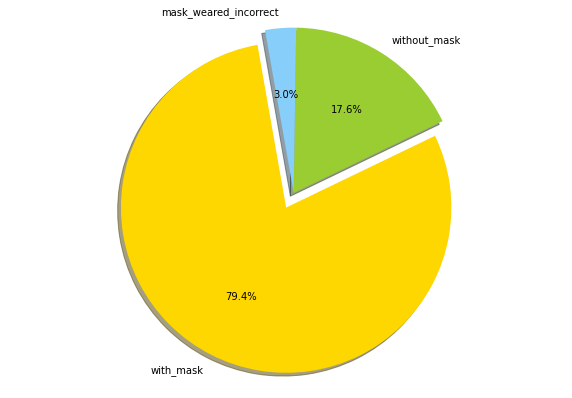

In [ ]:
fig = plt.figure(figsize =(10, 7))
# Data to plot
colors = ['gold', 'yellowgreen', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(df['Record Count'],explode=explode, labels = df['Labels'],colors=colors,
autopct='%1.1f%%', shadow=True, startangle=100)


plt.axis('equal')
plt.show()

### Plotting the bar chart

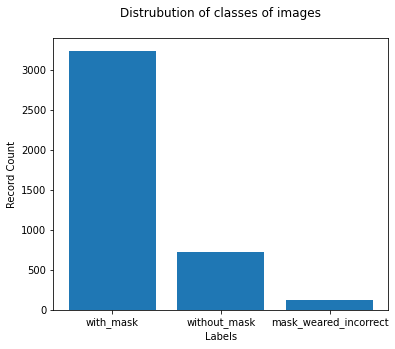

In [ ]:
fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(df['Labels'], df['Record Count'])
 
plt.xlabel("Labels")
plt.ylabel("Record Count")
plt.title("Distrubution of classes of images\n")
plt.show()

## Distribution of Classes of images after Data Augmentation

In [ ]:
# this is a similar function 
#it helps to extract the cropped images of the faces of people in the images
# we will later pass these cropped images to the model for training it
def face_extraction(directory_load_image,directory_load_notation):
        faces=[] #this will store the cropped images
        labels=[]
   
        with open(os.path.join(directory_load_notation,"maksssksksss459.xml" ), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]
            file="maksssksksss459.xml"

            #opening image
            image_name = file.replace("xml","png")
            im = Image.open(directory_load_image+image_name)

            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        crop_rectangle = (xmin, ymin, xmax , ymax) 
                        cropped_im = im.crop(crop_rectangle)  # cropping faces from the given image
                        faces.append(cropped_im)              # saving cropped images in the list
                        labels.append(object_["name"])
        return faces,labels

# executing the function      
faces,labels=face_extraction(image_dir,annot_dir)


with_mask


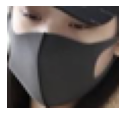

In [ ]:
#printing the 1st image
plt.figure(figsize=(2,2)) 
plt.imshow(faces[0])  
plt.axis('off')
print(labels[0]) 

with_mask


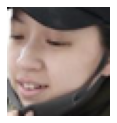

In [ ]:
#printing the 2nd image
plt.figure(figsize=(2,2)) 
plt.imshow(faces[1])   
plt.axis('off')
print(labels[1]) 

# Data pre-processing


In [ ]:
# this function saves the cropped images of faces in two folders(train_images and test_images)
# it also saves the labels("with_mask" or "without_mask") of these cropped images in two lists y_train and y_test
# we are splitting our data in to train and test. one for training our model and other for testing our model
# it will also resize our images to (100,100) as all images are of different sizes so to maintain uniformity in our data it will resize the images
def cropping_images(directory_load_image,directory_load_notation,directory_save_train,directory_save_test):
    y_train = []
    y_test = []
    i=1
    
    if not os.path.exists(directory_save_train):
        os.makedirs(directory_save_train)
    if not os.path.exists(directory_save_test):
        os.makedirs(directory_save_test)
    
    for file in os.listdir(directory_load_notation):
        with open(os.path.join(directory_load_notation, file), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]


            #opening image
            image_name = file.replace("xml","png")
            im = Image.open(directory_load_image+image_name)

            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        
                        #cropping the face and saving it
                        crop_rectangle = (xmin, ymin, xmax , ymax)
                        cropped_im = im.crop(crop_rectangle)
                        resized_im = cropped_im.resize((100,100), Image.ANTIALIAS)
                        
                        #this part is for sperating train set from test set
                        if i<3600:
                            resized_im.save(directory_save_train+str(i)+".png")
                            y_train.append(object_["name"])
                        else:
                            resized_im.save(directory_save_test+str(i-3599)+".png")
                            y_test.append(object_["name"])

                        i+=1
            else:
                #same thing on images with one face in them
                object_ = object_list
                xmin = int(object_["bndbox"]["xmin"])
                xmax = int(object_["bndbox"]["xmax"])
                ymin = int(object_["bndbox"]["ymin"])
                ymax = int(object_["bndbox"]["ymax"])

                crop_rectangle = (xmin, ymin, xmax , ymax)
                cropped_im = im.crop(crop_rectangle)
                resized_im = cropped_im.resize((100, 100), Image.ANTIALIAS)
                if i<3600:
                    resized_im.save(directory_save_train+str(i)+".png")
                    y_train.append(object_["name"])
                else:
                    resized_im.save(directory_save_test+str(i-3599)+".png")
                    y_test.append(object_["name"])

                i+=1
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return y_train,y_test


In [ ]:
# executing the previous function
y_train,y_test = cropping_images(image_dir,annot_dir,train_dir,test_dir)


In [ ]:
# it will count the number of items in our list (Splitting the data - Train/Test : 80-20 Ratio)
print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({'with_mask': 2860, 'without_mask': 632, 'mask_weared_incorrect': 107})
Counter({'with_mask': 372, 'without_mask': 85, 'mask_weared_incorrect': 16})


In [ ]:
# Converting to dataframe
dictionary_train = dict(collections.Counter(y_train))
df2 = pd.DataFrame(dictionary_train.items(), columns=['Labels',	'Record Count'])

In [ ]:
df2

,Labels,Record Count
0,with_mask,2860
1,without_mask,632
2,mask_weared_incorrect,107


In [ ]:
# Converting to dataframe
dictionary_test = dict(collections.Counter(y_test))
df3 = pd.DataFrame(dictionary_test.items(), columns=['Labels',	'Record Count'])

In [ ]:
df3

,Labels,Record Count
0,without_mask,85
1,with_mask,372
2,mask_weared_incorrect,16


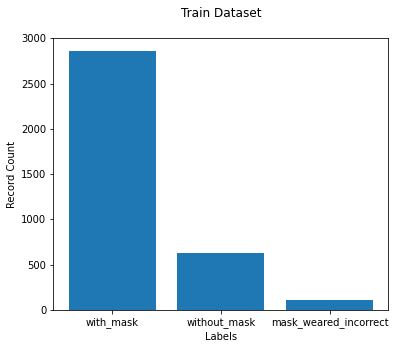

In [ ]:
fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(df2['Labels'], df2['Record Count'])
 
plt.xlabel("Labels")
plt.ylabel("Record Count")
plt.title("Train Dataset\n")
plt.show()

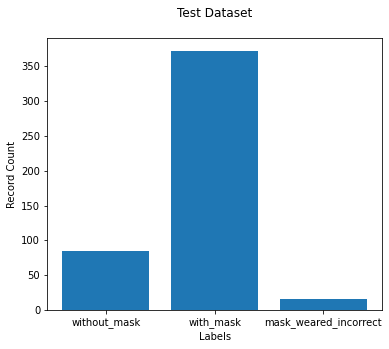

In [ ]:
fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(df3['Labels'], df3['Record Count'])
 
plt.xlabel("Labels")
plt.ylabel("Record Count")
plt.title("Test Dataset\n")
plt.show()

### Images
- With Mask
- Without Mask
- Mask Weared Incorrect

(-0.5, 99.5, 99.5, -0.5)

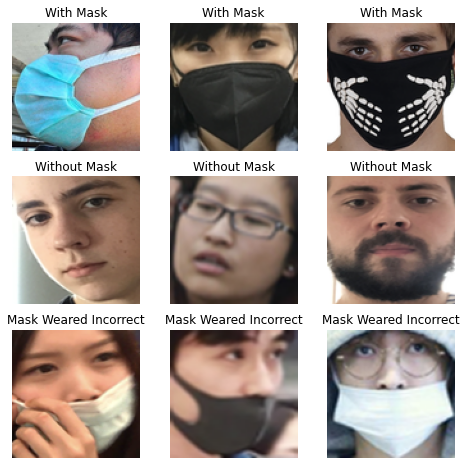

In [ ]:
plt.figure(figsize = (8 ,8))
plt.axis('off')

# With Mask
plt.subplot(3, 3, 1)
plt.title('With Mask')
plt.imshow(load_img(os.path.join(train_dir,'27.png')))
plt.axis('off')


plt.subplot(3, 3, 2)
plt.title('With Mask')
#plt.imshow(load_img(train_wear_mask.query("is_wear == '1'").dir.iloc[2], target_size = (268, 400, 3)))
plt.imshow(load_img(os.path.join(train_dir,'205.png')))
plt.axis('off')


plt.subplot(3, 3, 3)
plt.title('With Mask')
plt.imshow(load_img(os.path.join(train_dir,'215.png')))
plt.axis('off')



# Without Mask
plt.subplot(3, 3, 4)
plt.title('Without Mask')
plt.imshow(load_img(os.path.join(train_dir,'108.png')))
plt.axis('off')

plt.subplot(3, 3, 5)
plt.title('Without Mask')
plt.imshow(load_img(os.path.join(train_dir,'129.png')))
plt.axis('off')


plt.subplot(3, 3, 6)
plt.title('Without Mask')
plt.imshow(load_img(os.path.join(train_dir,'376.png')))
plt.axis('off')



# Mask Weared Incorrect
plt.subplot(3, 3, 7)
plt.title('Mask Weared Incorrect')
plt.imshow(load_img(os.path.join(train_dir,'200.png')))
plt.axis('off')


plt.subplot(3, 3, 8)
plt.title('Mask Weared Incorrect')
plt.imshow(load_img(os.path.join(train_dir,'202.png')))
plt.axis('off')


plt.subplot(3, 3, 9)
plt.title('Mask Weared Incorrect')
plt.imshow(load_img(os.path.join(train_dir,'570.png')))
plt.axis('off')
